In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

np.random.seed(69)

In [2]:
data = pd.read_csv('train.csv')
data = data.replace([np.inf, -np.inf], np.nan)

In [3]:
columns = list(data.columns)
y = np.array(data['y'])
np.save('Data/y.npy', y)

data = data[columns[1:-1]]

In [4]:
columns = data.columns

columns_without_nan = data.columns[data.isna().sum() == 0]
columns_with_nan = data.columns[data.isna().sum() > 0]

In [6]:
damaged_data = data[columns_with_nan]

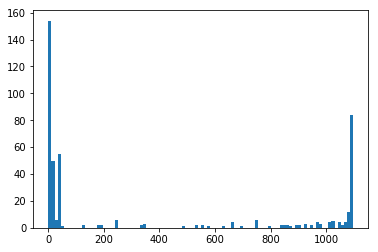

In [10]:
plt.hist(damaged_data.isna().sum(), bins=100)
plt.show()

#### Drop columns with more than 100 nan values

In [12]:
damaged_data = damaged_data[damaged_data.columns[damaged_data.isna().sum() <= 100]]

#### Find columns with real values and fill them with mean

In [14]:
def is_real(column):
    column = column[~column.isna()]
    if (column != column.astype(int)).sum() > 0:
        return True
    else:
        return False

In [15]:
damaged_real_columns = []
damaged_cat_columns = []

for c in damaged_data.columns:
    if is_real(damaged_data[c]):
        damaged_real_columns.append(c)
    else:
        damaged_cat_columns.append(c)

In [17]:
len(damaged_real_columns), len(damaged_cat_columns)

(264, 2)

In [22]:
len(set(damaged_data[damaged_cat_columns[1]])), len(set(damaged_data[damaged_cat_columns[0]]))

(852, 891)

In [28]:
scipy.stats.mode(damaged_data[damaged_cat_columns[1]])[0][0], scipy.stats.mode(damaged_data[damaged_cat_columns[0]])

(2580.0, ModeResult(mode=array([22528.]), count=array([5])))

#### Fill real_columns with mean and cat_columns with modes

In [29]:
def fill_with_mean(column):
    array = column[~column.isna()]
    mean = array.mean()
    return column.fillna(mean)

def fill_with_mode(column):
    mode = scipy.stats.mode(column)[0][0]
    return mode

In [34]:
for c in damaged_real_columns:
    damaged_data[c] = fill_with_mean(damaged_data[c])
    
for c in damaged_cat_columns:
    damaged_data[c] = fill_with_mode(damaged_data[c])

#### Undamaged data

In [38]:
undamaged_data = data[columns_without_nan]

In [39]:
undamaged_real_columns = []
undamaged_cat_columns = []

for c in undamaged_data.columns:
    if is_real(undamaged_data[c]):
        undamaged_real_columns.append(c)
    else:
        undamaged_cat_columns.append(c)

#### Merge data

In [58]:
merged_real_columns = undamaged_real_columns + damaged_real_columns
merged_cat_columns = undamaged_cat_columns + damaged_cat_columns

In [59]:
merged_data = pd.concat([undamaged_data, damaged_data], axis=1)

In [60]:
merged_data.shape, len(merged_real_columns + merged_cat_columns)

((1095, 1438), 1438)

#### drop constant columns

In [61]:
constant_columns = list(merged_data.columns[merged_data.std(axis=0) == 0])

In [62]:
merged_real_columns = list(set(merged_real_columns) - set(constant_columns))
merged_cat_columns = list(set(merged_cat_columns) - set(constant_columns))

merged_data = merged_data[merged_data.columns[merged_data.std(axis=0) > 0]]

merged_data.shape, len(merged_real_columns + merged_cat_columns)

((1095, 1311), 1311)

#### Drop high-corr features

In [63]:
merged_real = merged_data[merged_real_columns]

In [64]:
temp = merged_real
corr_matrix = temp.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
temp = temp.drop(columns=to_drop)

print(temp.shape)

(1095, 594)


In [65]:
real_columns_to_keep = list(temp.columns)

In [69]:
len(real_columns_to_keep + merged_cat_columns)

815

In [68]:
final_data = merged_data[real_columns_to_keep + merged_cat_columns]

In [71]:
np.save('Data/extended_data.npy', np.array(final_data))